In [1]:
# Python version of MCTS implementation for performance comparison
from mcts import MCTS
import numpy as np
import time
import math
from actionspace import map_w, map_b
from rchess import Move, Board
from model import predict_fn, predict_model
from chess import Board as TbBoard
import chess.syzygy as syzygy
import os
from configs import engineplayConfig

class NodePy:
    def __init__(self, p):
        self.P = p
        self.W = 0.0
        self.N = 0
        self.vloss = 0
        self.children = {}
        self.to_play = False
        self.debug_info = {}

    def __getitem__(self, move):
        return self.children[move]
    
    def __setitem__(self, move, node):
        self.children[move] = node

    def get_child(self, move):
        return self.children[move]

    def add_child(self, move, p):
        self.children[move] = NodePy(p)

    def is_leaf(self):
        return not self.children

    def apply_vloss(self):
        self.N += 1
        self.W -= 1
        self.vloss += 1

    def remove_vloss(self):
        self.N -= self.vloss
        self.W += self.vloss
        self.vloss = 0

class MCTSPy:
    def __init__(self, cfg):
        self.history_flip = cfg['history_perspective_flip']
        self.root_exploration_noise = cfg['root_exploration_noise']
        self.root_dirichlet_alpha = cfg['root_dirichlet_alpha']
        self.root_exploration_fraction = cfg['root_exploration_fraction']
        self.fpu_root = cfg['fpu_root']
        self.fpu_leaf = cfg['fpu_leaf']
        self.pb_c_init = cfg['pb_c_init']
        self.pb_c_factor = cfg['pb_c_factor']
        self.pb_c_base = cfg['pb_c_base']
        self.moves_softmax_temp = cfg['moves_softmax_temp']
        self.num_vl_searches = cfg['num_vl_searches']
        self.num_mcts_sampling_moves = cfg['num_mcts_sampling_moves']
        self.resignation_threshold = cfg['resignation_threshold']
        self.tablebase_search = cfg['tablebase_search']

        self.num_planes = 109
        self.rng = np.random.default_rng()
        self.m_w = map_w
        self.m_b = map_b

        self.tablebase = syzygy.open_tablebase(os.path.join(cfg['project_dir'], 'syzygy/3-4-5'))

    def get_history_flip(self):
        return self.history_flip

    def expand_root(self, board, root, trt_func, debug):
        if root is None:
            root = NodePy(0.0) 
        batch = np.zeros((self.num_vl_searches, self.num_planes), dtype=np.int64)

        root.to_play = board.to_play()
        history, _ = board.history(self.history_flip)

        for idx in range(self.num_planes):
            batch[0, idx] = history[idx]
        _, policy_logits = make_predictions_py(
                trt_func=trt_func,
                batch=batch
            )
        self.expand_and_evaluate_node(root, policy_logits[0], board.legal_moves_tuple(), debug)
        return root

    def search(self, board, root, trt_func, debug):
        nodes_to_eval = []
        moves_to_nodes = []
        eval_nodes_legal_moves = []
        failsafe = 0
        nodes_found = 0
        nodes_to_find = self.num_vl_searches
        batch = np.zeros((self.num_vl_searches, self.num_planes), dtype=np.int64)

        while nodes_found < nodes_to_find and failsafe < 2:
            depth_to_root = 0
            node = root
            tmp_board = board.clone()
            while not node.is_leaf():
                fpu = self.fpu_leaf if depth_to_root > 0 else self.fpu_root
                move_num = select_child_py(node, pb_c_base=self.pb_c_base, pb_c_init=self.pb_c_init, pb_c_factor=self.pb_c_factor, fpu=fpu, debug=debug)
                node = node[move_num]
                tmp_board.push_num(move_num)
                depth_to_root += 1
            
            terminal, is_drawn = tmp_board.mid_search_terminal(depth_to_root)
            if terminal:
                value = 0.5 if is_drawn else 0.0
                update_py(root, tmp_board.moves_history(depth_to_root), value)
                if debug:
                    node.debug_info["init_value"] = flip_value_py(value)
                failsafe += 1
                continue

            moves_to_node = tmp_board.moves_history(depth_to_root)
            add_vloss_py(root, moves_to_node)

            node.to_play = tmp_board.to_play()

            nodes_to_eval.append(node)
            moves_to_nodes.append(moves_to_node)
            eval_nodes_legal_moves.append(tmp_board.legal_moves_tuple())
            history, _ = tmp_board.history(self.history_flip)
            for idx in range(self.num_planes):
                batch[nodes_found, idx] = history[idx]
            nodes_found += 1

        if nodes_found == 0:
            return root

        values, policy_logits = make_predictions_py(
            trt_func=trt_func,
            batch=batch
        )
        
        for idx in range(nodes_found):
            self.expand_and_evaluate_node(nodes_to_eval[idx], policy_logits[idx], eval_nodes_legal_moves[idx], debug)
            value = value_to_01_py(values[idx].item())
            update_py(root, moves_to_nodes[idx], value)
            if debug:
                nodes_to_eval[idx].debug_info["init_value"] = flip_value_py(value)
        return root

    def find_best_move(self, board, root, trt_func, num_sims, time_limit, debug):
        assert (num_sims > 0) != (time_limit > 0.0), "Only one & at least one, either num_sims or time_limit, must be greater than 0."

        batch = np.zeros((self.num_vl_searches, self.num_planes), dtype=np.int64)
        time_limit_set = True if time_limit > 0.0 else False

        if root is None or root.is_leaf():
            root = NodePy(0.0)
            root.to_play = board.to_play()

        if root.is_leaf():
            history, _ = board.history(self.history_flip)
            for idx in range(self.num_planes):
                batch[0, idx] = history[idx]
            _, policy_logits = make_predictions_py(
                    trt_func=trt_func,
                    batch=batch
                )
            self.expand_and_evaluate_node(root, policy_logits[0], board.legal_moves_tuple(), debug)
            root.N += 1

        if self.root_exploration_noise:
            add_exploration_noise_py(root, self.rng, self.root_dirichlet_alpha, self.root_exploration_fraction)

        start_time = time.time()

        while True:
            if time_limit_set:
                if time.time() - start_time > time_limit:
                    break
                nodes_to_find = self.num_vl_searches
            else:
                if root.N >= num_sims:
                    break
                nodes_to_find = self.num_vl_searches if root.N + self.num_vl_searches <= num_sims else num_sims - root.N
            nodes_found = 0
            nodes_to_eval = []
            eval_nodes_legal_moves = []
            moves_to_nodes = []
            failsafe = 0
            while nodes_found < nodes_to_find and failsafe < 2:
                depth_to_root = 0
                node = root
                tmp_board = board.clone()
                while not node.is_leaf():
                    fpu = self.fpu_leaf if depth_to_root > 0 else self.fpu_root
                    move_num = select_child_py(node, pb_c_base=self.pb_c_base, pb_c_init=self.pb_c_init, pb_c_factor=self.pb_c_factor, fpu=fpu, debug=debug)
                    node = node[move_num]
                    tmp_board.push_num(move_num)
                    depth_to_root += 1
                
                terminal, is_drawn = tmp_board.mid_search_terminal(depth_to_root)
                if terminal:
                    value = 0.5 if is_drawn else 0.0
                    update_py(root, tmp_board.moves_history(depth_to_root), value)
                    if debug:
                        node.debug_info["init_value"] = flip_value_py(value)
                    failsafe += 1
                    continue

                # If tablebase search is enabled, check if the position is in the tablebase
                if self.tablebase_search and tmp_board.pieces_on_board() <= 5:
                    tb_board = TbBoard(tmp_board.fen())
                    wdl = self.tablebase.get_wdl(tb_board)
                    if wdl is not None and not (wdl == 1 or wdl == -1):
                        if wdl == 0:
                            value = 0.5
                        else:
                            to_play = tmp_board.to_play()
                            winner = to_play if wdl > 0 else not to_play
                            value = 1.0 if winner == to_play else 0.0
                        update_py(root, tmp_board.moves_history(depth_to_root), value)
                        if debug:
                            node.debug_info["init_value"] = flip_value_py(value)
                        failsafe += 1
                        continue

                moves_to_node = tmp_board.moves_history(depth_to_root)
                add_vloss_py(root, moves_to_node)

                node.to_play = tmp_board.to_play()

                nodes_to_eval.append(node)
                moves_to_nodes.append(moves_to_node)
                eval_nodes_legal_moves.append(tmp_board.legal_moves_tuple())
                history, _ = tmp_board.history(self.history_flip)
                for idx in range(self.num_planes):
                    batch[nodes_found, idx] = history[idx]
                nodes_found += 1

            if nodes_found == 0:
                failsafe += 1
                continue

            values, policy_logits = make_predictions_py(
                    trt_func=trt_func,
                    batch=batch
                )
            
            for idx in range(nodes_found):
                self.expand_and_evaluate_node(nodes_to_eval[idx], policy_logits[idx], eval_nodes_legal_moves[idx], debug)
                value = value_to_01_py(values[idx].item())
                update_py(root, moves_to_nodes[idx], value)
                if debug:
                    nodes_to_eval[idx].debug_info["init_value"] = flip_value_py(value)

        end_time = time.time()
        if debug:
            root.debug_info["elapsed_time"] = end_time - start_time
        
        move_num = self.select_best_move(root, temp=self.moves_softmax_temp if board.ply() <= self.num_mcts_sampling_moves else 0.0)
        child_visits = self.calculate_search_statistics(root)
        
        if board.ply() > self.num_mcts_sampling_moves and self.resignation_threshold > 0.0:
            q = root[move_num].W / root[move_num].N if root[move_num].N > 0 else self.fpu_root
            if q < self.resignation_threshold:
                move_num = 0 # Resignation move

        return move_num, root, child_visits

    def expand_and_evaluate_node(self, node, policy_logits, legal_moves_tuple, debug):
        m = self.m_w if node.to_play else self.m_b
        moves_count = len(legal_moves_tuple)
        policy = np.zeros(moves_count, dtype=np.float32)
        
        for i in range(moves_count):
            move_uci = legal_moves_tuple[i][1]
            p_idx = m[move_uci]
            p = policy_logits[p_idx]
            policy[i] = p

        # Softmax
        _max = np.max(policy)
        policy = policy - _max
        exp_policy = np.exp(policy)
        policy = exp_policy / np.sum(exp_policy)

        for i in range(moves_count):
            node.add_child(legal_moves_tuple[i][0], policy[i])
        if debug:
            for i in range(moves_count):
                child = node.children[legal_moves_tuple[i][0]]
                child.debug_info["move_uci"] = legal_moves_tuple[i][1]
                child.debug_info["move_num"] = legal_moves_tuple[i][0]

    def calculate_search_statistics(self, root):
        child_visits = np.zeros(1858, dtype=np.float32)
        m = self.m_w if root.to_play else self.m_b
        
        _sum = 0.0
        for move_num, child in root.children.items():
            cN = child.N
            move_str = Move(move_num).uci()
            i = m[move_str]
            child_visits[i] = float(cN)
            _sum += float(cN)
        child_visits /= _sum
        return child_visits

    def select_best_move(self, node, temp):
        moves = list(node.children.keys())
        probs = np.array([node[move].N for move in moves])
        if temp == 0.0:
            return moves[np.argmax(probs)]
        else:
            probs = np.power(probs, 1.0 / temp)
            probs /= np.sum(probs)
            return self.rng.choice(moves, p=probs)

# Helper functions
def add_exploration_noise_py(node, rng, dirichlet_alpha, exploration_fraction):
    noise = rng.dirichlet([dirichlet_alpha] * len(node.children)).astype(np.float32)
    
    i = 0
    for child in node.children.values():
        child.P = child.P * (1 - exploration_fraction) + noise[i] * exploration_fraction
        i += 1

def make_predictions_py(trt_func, batch):
    if is_trt_func(trt_func):
        values_tf, policy_logits_tf = predict_fn(
            trt_func=trt_func,
            images=batch
        )
        values = np.array(values_tf, dtype=np.float32)
        policy_logits = np.array(policy_logits_tf, dtype=np.float32)
        return values, policy_logits
    else:
        values, policy_logits = predict_model(
            model=trt_func,
            images=batch
        )
        values = np.array(values, dtype=np.float32)
        policy_logits = np.array(policy_logits, dtype=np.float32)
        return values, policy_logits


def select_child_py(node, pb_c_base, pb_c_init, pb_c_factor, fpu, debug):
    bestmove = 0
    bestucb = -99.9
    N = node.N
    pN_sqrt = math.sqrt(N)
    pb_c = PB_C_py(N, pb_c_base, pb_c_init, pb_c_factor)

    for move, child in node.children.items():
        cN = child.N
        cQ = child.W / cN if cN > 0 else fpu
        ucb = cQ + UCB_py(cN, child.P, pN_sqrt, pb_c)
        if ucb > bestucb:
            bestucb = ucb
            bestmove = move
        if debug:
            child.debug_info["ucb"] = ucb
    
    return bestmove 

def UCB_py(cN, cP, pN_sqrt, pb_c):
    return pb_c * cP * (pN_sqrt / (cN + 1))

def PB_C_py(pN, pb_c_base, pb_c_init, pb_c_factor):
    return math.log((pN + pb_c_base + 1) / pb_c_base) * pb_c_factor + pb_c_init

def value_to_01_py(value):
    return (value + 1.0) / 2.0

def clip_value_py(value, amount):
    max_value = 1.0 - amount
    if value > max_value:
        return max_value
    else:
        return value

def flip_value_py(value):
    return 1.0 - value

def update_py(root, moves_to_leaf, value):
    root.N += 1
    node = root
    moves_count = len(moves_to_leaf)
    if moves_count % 2 == 1:
        value = flip_value_py(value)
    for move in moves_to_leaf:
        node = node[move]
        node.remove_vloss()
        node.N += 1
        node.W += value
        value = flip_value_py(value)

def add_vloss_py(root, moves_to_leaf):
    node = root
    for move in moves_to_leaf:
        node = node[move]
        node.apply_vloss()

def is_trt_func(obj):
    # TensorRT function is a _WrapperFunction with a 'structured_input_signature' attribute
    return hasattr(obj, 'structured_input_signature') and callable(obj)

print("Python MCTS implementation loaded for performance comparison")

Python MCTS implementation loaded for performance comparison


In [2]:
# self, board, root, trt_func, num_sims, time_limit, debug):
def test_mcts_performance(model, mctsSearch, num_simulations=800, time_limit=10, runs=5):
    board = Board()
    times = []
    nps_counts = []
    if time_limit > 0.0:
        num_simulations = 0
    for i in range(runs):
        t1 = time.time()
        _, root, _ = mctsSearch.find_best_move(
            board,
            None,
            model,
            num_sims=num_simulations,
            time_limit=time_limit,
            debug=False)
        t2 = time.time()
        times.append(t2 - t1)
        nps_counts.append(root.N / time_limit)
        del root
    avg_time = sum(times) / len(times)
    avg_nps = sum(nps_counts) / len(nps_counts)
    return avg_nps, avg_time

In [3]:
from model import generate_model, update_trt_model, load_as_trt_model
from configs import defaultConfig

fp32_model_1 = "test_fp32_1"
fp32_model_16 = "test_fp32_16"
fp32_model_32 = "test_fp32_32"

fp16_model_1 = "test_fp16_1"
fp16_model_16 = "test_fp16_16"
fp16_model_32 = "test_fp16_32"

#model = generate_model()
#data_dir = os.path.join(defaultConfig['project_dir'], 'data')
#model.save(os.path.join(data_dir, 'models', 'model.keras'))

""" defaultConfig['num_vl_searches'] = 1
update_trt_model(defaultConfig, fp32_model_1, precision_mode='FP32')
update_trt_model(defaultConfig, fp16_model_1, precision_mode='FP16')

defaultConfig['num_vl_searches'] = 16
update_trt_model(defaultConfig, fp32_model_16, precision_mode='FP32')
update_trt_model(defaultConfig, fp16_model_16, precision_mode='FP16')

defaultConfig['num_vl_searches'] = 32
update_trt_model(defaultConfig, fp32_model_32, precision_mode='FP32')
update_trt_model(defaultConfig, fp16_model_32, precision_mode='FP16') """


" defaultConfig['num_vl_searches'] = 1\nupdate_trt_model(defaultConfig, fp32_model_1, precision_mode='FP32')\nupdate_trt_model(defaultConfig, fp16_model_1, precision_mode='FP16')\n\ndefaultConfig['num_vl_searches'] = 16\nupdate_trt_model(defaultConfig, fp32_model_16, precision_mode='FP32')\nupdate_trt_model(defaultConfig, fp16_model_16, precision_mode='FP16')\n\ndefaultConfig['num_vl_searches'] = 32\nupdate_trt_model(defaultConfig, fp32_model_32, precision_mode='FP32')\nupdate_trt_model(defaultConfig, fp16_model_32, precision_mode='FP16') "

In [4]:
# Each test now appends its results as: (Implementation, Model_Precision, Virtual_Loss, Avg_NPS)
performance_results = []

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(defaultConfig['project_dir'], 'data', 'models', 'model.keras'))

In [6]:
engineplayConfig['num_vl_searches'] = 1
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(model, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsPy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Python', 'Model', 'None', 1, avg_nps))

engineplayConfig['num_vl_searches'] = 16
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(model, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsPy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Python', 'Model', 'None', 16, avg_nps))

engineplayConfig['num_vl_searches'] = 32
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(model, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsPy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Python', 'Model', 'None', 32, avg_nps))

In [7]:
engineplayConfig['num_vl_searches'] = 1
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(model, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsCy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Cython', 'Model', 'None', 1, avg_nps))

engineplayConfig['num_vl_searches'] = 16
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(model, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsCy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Cython', 'Model', 'None', 16, avg_nps))

engineplayConfig['num_vl_searches'] = 32
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(model, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(model, mctsCy, time_limit=10, runs=10)
performance_results.append(('RustChess', 'Cython', 'Model', 'None', 32, avg_nps))

In [8]:
performance_results

[('RustChess', 'Python', 'Model', 'None', 1, 385.3),
 ('RustChess', 'Python', 'Model', 'None', 16, 2398.7),
 ('RustChess', 'Python', 'Model', 'None', 32, 2926.31),
 ('RustChess', 'Cython', 'Model', 'None', 1, 474.10999999999996),
 ('RustChess', 'Cython', 'Model', 'None', 16, 5201.370000000001),
 ('RustChess', 'Cython', 'Model', 'None', 32, 7992.58)]

In [ ]:
trt_func, loaded_model = load_as_trt_model(fp32_model_1)
engineplayConfig['num_vl_searches'] = 1

# Python, FP32, no virtual loss
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP32][VL_1] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP32", 1, avg_nps))

# Cython, FP32, no virtual loss
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP32][VL_1] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP32", 1, avg_nps))

del trt_func, loaded_model
trt_func, loaded_model = load_as_trt_model(fp16_model_1)

# Python, FP16, no virtual loss
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP16][VL_1] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP16", 1, avg_nps))

# Cython, FP16, no virtual loss
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP16][VL_1] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP16", 1, avg_nps))

2025-07-03 13:56:04.566052: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP32][VL_1] - Average NPS: 686.1
[CythonMCTS][FP32][VL_1] - Average NPS: 816.1


2025-07-03 13:58:07.022661: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP16][VL_1] - Average NPS: 835.0
[CythonMCTS][FP16][VL_1] - Average NPS: 1032.7


In [ ]:
del trt_func, loaded_model
trt_func, loaded_model = load_as_trt_model(fp32_model_16)
engineplayConfig['num_vl_searches'] = 16

# Python, FP32, virtual loss 16
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP32][VL_16] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP32", 16, avg_nps))

# Cython, FP32, virtual loss 16
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP32][VL_16] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP32", 16, avg_nps))

del trt_func, loaded_model
trt_func, loaded_model = load_as_trt_model(fp16_model_16)

# Python, FP16, virtual loss 16
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP16][VL_16] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP16", 16, avg_nps))

# Cython, FP16, virtual loss 16
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP16][VL_16] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP16", 16, avg_nps))

2025-07-03 14:00:09.393758: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP32][VL_16] - Average NPS: 2692.9
[CythonMCTS][FP32][VL_16] - Average NPS: 7791.9


2025-07-03 14:02:12.884325: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP16][VL_16] - Average NPS: 2913.8
[CythonMCTS][FP16][VL_16] - Average NPS: 9414.3


In [ ]:
#del trt_func, loaded_model
trt_func, loaded_model = load_as_trt_model(fp32_model_32)
engineplayConfig['num_vl_searches'] = 32

# Python, FP32, virtual loss 32
mctsPy = MCTSPy(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP32][VL_32] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP32", 32, avg_nps))

# Cython, FP32, virtual loss 32
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP32][VL_32] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP32", 32, avg_nps))

del trt_func, loaded_model
trt_func, loaded_model = load_as_trt_model(fp16_model_32)

# Python, FP16, virtual loss 32
_, _ = test_mcts_performance(trt_func, mctsPy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsPy, time_limit=10, runs=5)
print(f"[PythonMCTS][FP16][VL_32] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Python", "FP16", 32, avg_nps))

# Cython, FP16, virtual loss 32
mctsCy = MCTS(engineplayConfig)
_, _ = test_mcts_performance(trt_func, mctsCy, num_simulations=50, runs=1) # warmup
avg_nps, avg_time = test_mcts_performance(trt_func, mctsCy, time_limit=10, runs=5)
print(f"[CythonMCTS][FP16][VL_32] - Average NPS: {avg_nps:.1f}")
performance_results.append(("RustChess", "Cython", "FP16", 32, avg_nps))

del trt_func, loaded_model

2025-07-03 14:04:16.735232: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP32][VL_32] - Average NPS: 2925.5
[CythonMCTS][FP32][VL_32] - Average NPS: 9055.2


2025-07-03 14:06:20.491655: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


[PythonMCTS][FP16][VL_32] - Average NPS: 3211.5
[CythonMCTS][FP16][VL_32] - Average NPS: 13914.4


In [14]:
from chess import Board as PyBoard
from rchess import Board as RBoard
import time
import pandas as pd

def pyboard_perft(board, depth):
    if depth == 0:
        return 1
    nodes = 0
    for move in board.legal_moves:
        board.push(move)
        nodes += pyboard_perft(board, depth - 1)
        board.pop()
    return nodes

# For RBoard (rchess), assuming similar API
def rboard_perft(board, depth):
    if depth == 0:
        return 1
    nodes = 0
    for move in board.legal_moves():
        board_copy = board.clone()
        board_copy.push(move)
        nodes += rboard_perft(board_copy, depth - 1)
    return nodes

perft_results = []
POSITIONS = {
    "Initial": "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",
    "KiwiPete (Pos 2)": "r3k2r/p1ppqpb1/bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPBBPPP/R3K2R w KQkq - ",
    "Pos 3": "8/2p5/3p4/KP5r/1R3p1k/8/4P1P1/8 w - - 0 1 "
}
DEPTHS = [3, 4] # Using [3, 4] as depth 5 can be very slow
RUNS = 5

def run_perft_test(board_class, perft_func, fen, depth, runs):
    """Runs perft test for a given board, depth, and number of runs, returning avg time and node count."""
    times = []
    nodes = 0
    for _ in range(runs):
        board = board_class(fen)
        start_time = time.time()
        # Node count is constant, so we only need to calculate it once.
        if nodes == 0:
            nodes = perft_func(board, depth)
        else:
            perft_func(board, depth) # Still run it to measure time
        end_time = time.time()
        times.append(end_time - start_time)
    return sum(times) / len(times), nodes

for name, fen in POSITIONS.items():
    for depth in DEPTHS:
        print(f"Testing Position: '{name}' at depth {depth}...")

        # Test python-chess
        py_avg_time, py_nodes = run_perft_test(PyBoard, pyboard_perft, fen, depth, RUNS)
        perft_results.append({
            "Position": name,
            "Depth": depth,
            "Library": "python-chess",
            "Avg Time (s)": py_avg_time,
            "Nodes": py_nodes
        })
        print(f"  python-chess: {py_nodes} nodes, avg time: {py_avg_time:.4f}s")

        # Test rchess
        r_avg_time, r_nodes = run_perft_test(RBoard, rboard_perft, fen, depth, RUNS)
        perft_results.append({
            "Position": name,
            "Depth": depth,
            "Library": "rchess",
            "Avg Time (s)": r_avg_time,
            "Nodes": r_nodes
        })
        print(f"  rchess: {r_nodes} nodes, avg time: {r_avg_time:.4f}s")
        print("-" * 30)

# Display results in a pandas DataFrame
df_perft = pd.DataFrame(perft_results)
print("\nPerft Test Summary:")
print(df_perft)


Testing Position: 'Initial' at depth 3...
  python-chess: 8902 nodes, avg time: 0.0795s
  rchess: 8902 nodes, avg time: 0.0049s
------------------------------
Testing Position: 'Initial' at depth 4...
  python-chess: 197281 nodes, avg time: 1.5495s
  rchess: 197281 nodes, avg time: 0.1048s
------------------------------
Testing Position: 'KiwiPete (Pos 2)' at depth 3...
  python-chess: 97862 nodes, avg time: 0.7435s
  rchess: 97862 nodes, avg time: 0.0495s
------------------------------
Testing Position: 'KiwiPete (Pos 2)' at depth 4...
  python-chess: 4085603 nodes, avg time: 31.7743s
  rchess: 4085603 nodes, avg time: 2.0843s
------------------------------
Testing Position: 'Pos 3' at depth 3...
  python-chess: 2812 nodes, avg time: 0.0234s
  rchess: 2812 nodes, avg time: 0.0015s
------------------------------
Testing Position: 'Pos 3' at depth 4...
  python-chess: 43238 nodes, avg time: 0.3737s
  rchess: 43238 nodes, avg time: 0.0236s
------------------------------

Perft Test Summa

In [15]:
df_perft

,Position,Depth,Library,Avg Time (s),Nodes
0,Initial,3,python-chess,0.079523,8902
1,Initial,3,rchess,0.004886,8902
2,Initial,4,python-chess,1.549467,197281
3,Initial,4,rchess,0.104834,197281
4,KiwiPete (Pos 2),3,python-chess,0.743532,97862
5,KiwiPete (Pos 2),3,rchess,0.049505,97862
6,KiwiPete (Pos 2),4,python-chess,31.774332,4085603
7,KiwiPete (Pos 2),4,rchess,2.084269,4085603
8,Pos 3,3,python-chess,0.023418,2812
9,Pos 3,3,rchess,0.001520,2812


In [16]:
perft_results

[{'Position': 'Initial',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.07952327728271484,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.004886007308959961,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 1.5494667530059814,
  'Nodes': 197281},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 0.10483388900756836,
  'Nodes': 197281},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.7435322761535644,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.04950494766235351,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 31.774331951141356,
  'Nodes': 4085603},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 2.084269094467163,
 

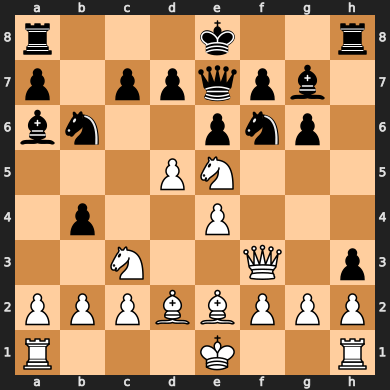

In [ ]:
from chess import Board as PyBoard
from rchess import Board as RBoard
import time


POSITION2 = "r3k2r/p1ppqpb1/bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPBBPPP/R3K2R w KQkq - "
POSITION3 = "8/2p5/3p4/KP5r/1R3p1k/8/4P1P1/8 w - - 0 1 "

def pyboard_perft(board, depth):
    if depth == 0:
        return 1
    nodes = 0
    for move in board.legal_moves:
        board.push(move)
        nodes += pyboard_perft(board, depth - 1)
        board.pop()
    return nodes

# For RBoard (rchess), assuming similar API
def rboard_perft(board, depth):
    if depth == 0:
        return 1
    nodes = 0
    for move in board.legal_moves():
        board_copy = board.clone()
        board_copy.push(move)
        nodes += rboard_perft(board_copy, depth - 1)
    return nodes

# INITIAL POSITION
pyboard = PyBoard()
rboard = RBoard()

DEPTH = 3

t1 = time.time()
py_nodes = pyboard_perft(pyboard, DEPTH)
t2 = time.time()
py_elapsed = t2 - t1

t3 = time.time()
r_nodes = rboard_perft(rboard, DEPTH)
t4 = time.time()
r_elapsed = t4 - t3

print(f"python-chess POS1 perft({DEPTH}): {py_nodes} nodes in {py_elapsed:.4f} seconds")
print(f"rchess POS1 perft({DEPTH}): {r_nodes} nodes in {r_elapsed:.4f} seconds")

# POSITION 2 A.K.A KiwiPete
pyboard = PyBoard(POSITION2)
rboard = RBoard(POSITION2)
t1 = time.time()
py_nodes = pyboard_perft(pyboard, DEPTH)
t2 = time.time()
py_elapsed = t2 - t1

t3 = time.time()
r_nodes = rboard_perft(rboard, DEPTH)
t4 = time.time()
r_elapsed = t4 - t3

print(f"python-chess POS1 perft({DEPTH}): {py_nodes} nodes in {py_elapsed:.4f} seconds")
print(f"rchess POS1 perft({DEPTH}): {r_nodes} nodes in {r_elapsed:.4f} seconds")

# POSITION 3 
pyboard = PyBoard(POSITION3)
rboard = RBoard(POSITION3)
t1 = time.time()
py_nodes = pyboard_perft(pyboard, DEPTH)
t2 = time.time()
py_elapsed = t2 - t1

t3 = time.time()
r_nodes = rboard_perft(rboard, DEPTH)
t4 = time.time()
r_elapsed = t4 - t3

print(f"python-chess POS1 perft({DEPTH}): {py_nodes} nodes in {py_elapsed:.4f} seconds")
print(f"rchess POS1 perft({DEPTH}): {r_nodes} nodes in {r_elapsed:.4f} seconds")

In [22]:
print(performance_results[8])
#performance_results[8] = ("Python", "FP32", 32, performance_results[8][3])  # Update the implementation name for consistency
new_performance_results = []
for lang, precision, vl, nps in performance_results:
    new_performance_results.append(("RustChess", lang, precision, vl, nps))
print(new_performance_results)
performance_results = new_performance_results

('Python', 'FP32', 32, 2925.5199999999995)
[('RustChess', 'Python', 'FP32', 1, 686.0799999999999), ('RustChess', 'Cython', 'FP32', 1, 816.1200000000001), ('RustChess', 'Python', 'FP16', 1, 835.04), ('RustChess', 'Cython', 'FP16', 1, 1032.7400000000002), ('RustChess', 'Python', 'FP32', 16, 2692.9), ('RustChess', 'Cython', 'FP32', 16, 7791.9400000000005), ('RustChess', 'Python', 'FP16', 16, 2913.7999999999997), ('RustChess', 'Cython', 'FP16', 16, 9414.34), ('RustChess', 'Python', 'FP32', 32, 2925.5199999999995), ('RustChess', 'Cython', 'FP32', 32, 9055.220000000001), ('RustChess', 'Python', 'FP16', 32, 3211.5199999999995), ('RustChess', 'Cython', 'FP16', 32, 13914.4)]


In [26]:
# Performance Comparison Results
import pandas as pd

# Create DataFrame from results
df = pd.DataFrame(performance_results, columns=['Library', 'Implementation', 'Model_Precision', 'Virtual_Loss', 'Avg_NPS'])

print("=" * 80)
print("MCTS PERFORMANCE COMPARISON RESULTS")
print("=" * 80)
print()

# Main comparison table
print("Complete Results:")
print("-" * 60)
for i, (lib, impl, precision, vl, nps) in enumerate(performance_results):
    print(f"{i+1:2d}. {lib:7s} | {impl:7s} | {precision:4s} | VL={vl:2d} | NPS: {nps:8.1f}")

print()
print("=" * 80)

# Group by implementation for direct comparison
python_results = [r for r in performance_results if r[0] == 'Python']
cython_results = [r for r in performance_results if r[0] == 'Cython']

print("SIDE-BY-SIDE COMPARISON:")
print("-" * 80)
print(f"{'Configuration':<25} {'Python NPS':<15} {'Cython NPS':<15} {'Speedup':<10}")
print("-" * 80)

# Pair up results by configuration
configurations = {}
for lib, impl, precision, vl, nps in performance_results:
    config_key = f"{precision}, VL={vl}"
    if config_key not in configurations:
        configurations[config_key] = {}
    configurations[config_key][impl] = nps

for config, results in configurations.items():
    if 'Python' in results and 'Cython' in results:
        python_nps = results['Python']
        cython_nps = results['Cython']
        speedup = cython_nps / python_nps
        print(f"{config:<25} {python_nps:<15.1f} {cython_nps:<15.1f} {speedup:<10.2f}x")

print()
print("=" * 80)

# Summary statistics
if python_results and cython_results:
    avg_python = sum(r[3] for r in python_results) / len(python_results)
    avg_cython = sum(r[3] for r in cython_results) / len(cython_results)
    overall_speedup = avg_cython / avg_python
    
    print("SUMMARY:")
    print(f"Average Python NPS:  {avg_python:8.1f}")
    print(f"Average Cython NPS:  {avg_cython:8.1f}")
    print(f"Overall Speedup:     {overall_speedup:8.2f}x")
    print()
    
    # Find best and worst performing configurations
    best_config = max(performance_results, key=lambda x: x[3])
    worst_config = min(performance_results, key=lambda x: x[3])
    
    print(f"Best Performance:  {best_config[0]} {best_config[1]} VL={best_config[2]} - {best_config[3]:.1f} NPS")
    print(f"Worst Performance: {worst_config[0]} {worst_config[1]} VL={worst_config[2]} - {worst_config[3]:.1f} NPS")

print("=" * 80)

MCTS PERFORMANCE COMPARISON RESULTS

Complete Results:
------------------------------------------------------------
 1. RustChess | Python  | FP32 | VL= 1 | NPS:    686.1
 2. RustChess | Cython  | FP32 | VL= 1 | NPS:    816.1
 3. RustChess | Python  | FP16 | VL= 1 | NPS:    835.0
 4. RustChess | Cython  | FP16 | VL= 1 | NPS:   1032.7
 5. RustChess | Python  | FP32 | VL=16 | NPS:   2692.9
 6. RustChess | Cython  | FP32 | VL=16 | NPS:   7791.9
 7. RustChess | Python  | FP16 | VL=16 | NPS:   2913.8
 8. RustChess | Cython  | FP16 | VL=16 | NPS:   9414.3
 9. RustChess | Python  | FP32 | VL=32 | NPS:   2925.5
10. RustChess | Cython  | FP32 | VL=32 | NPS:   9055.2
11. RustChess | Python  | FP16 | VL=32 | NPS:   3211.5
12. RustChess | Cython  | FP16 | VL=32 | NPS:  13914.4

SIDE-BY-SIDE COMPARISON:
--------------------------------------------------------------------------------
Configuration             Python NPS      Cython NPS      Speedup   
------------------------------------------------

In [ ]:
df

,Library,Implementation,Model_Precision,Virtual_Loss,Avg_NPS
0,RustChess,Python,FP32,1,686.08
1,RustChess,Cython,FP32,1,816.12
2,RustChess,Python,FP16,1,835.04
3,RustChess,Cython,FP16,1,1032.74
4,RustChess,Python,FP32,16,2692.90
5,RustChess,Cython,FP32,16,7791.94
6,RustChess,Python,FP16,16,2913.80
7,RustChess,Cython,FP16,16,9414.34
8,RustChess,Python,FP32,32,2925.52
9,RustChess,Cython,FP32,32,9055.22


: 

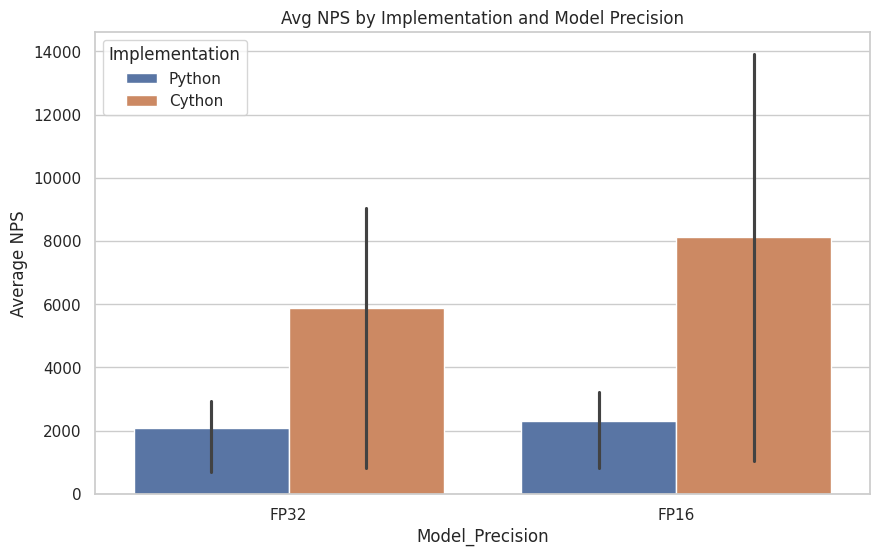

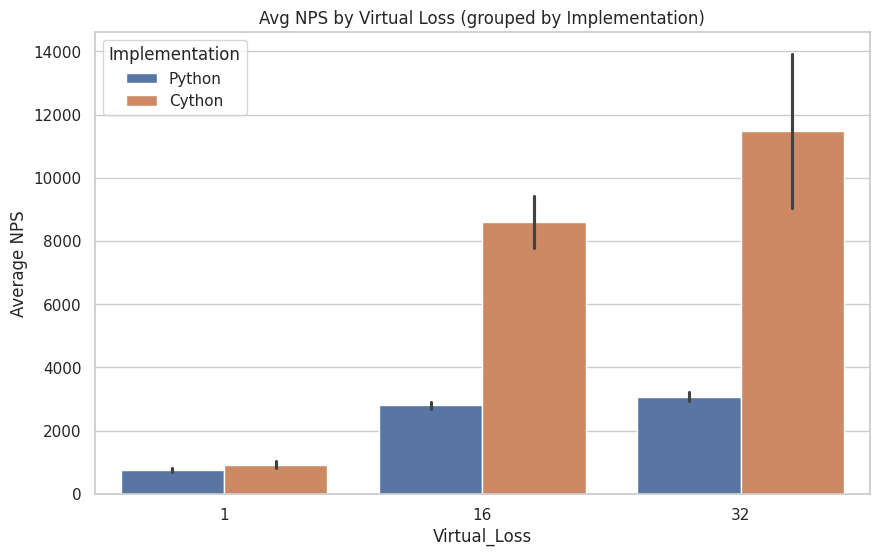

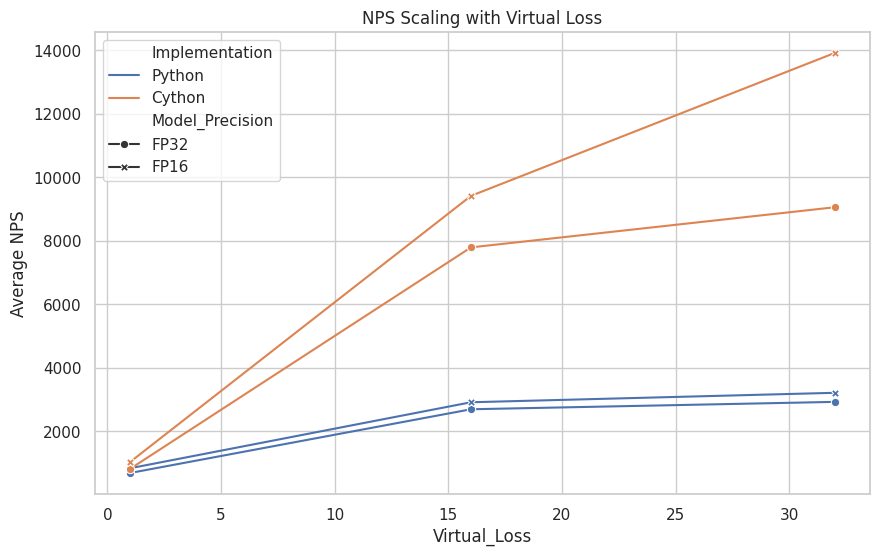

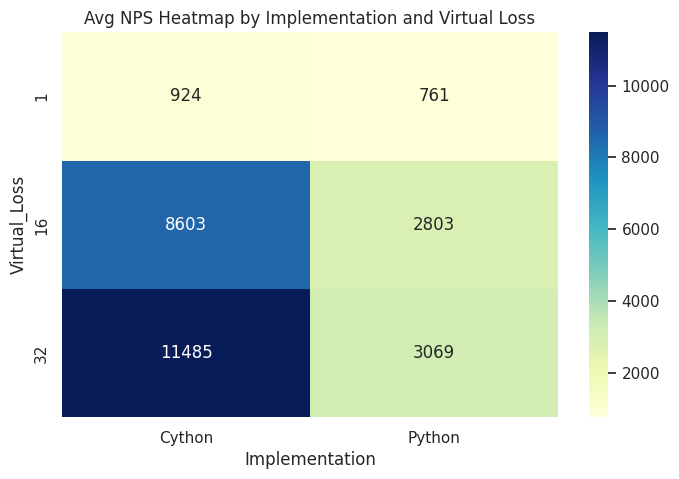

Mean NPS by Implementation:
Implementation
Cython    7004.126667
Python    2210.810000
Name: Avg_NPS, dtype: float64

Mean NPS by Model_Precision:
Model_Precision
FP16    5220.306667
FP32    3994.630000
Name: Avg_NPS, dtype: float64

Mean NPS by Virtual_Loss:
Virtual_Loss
1      842.495
16    5703.245
32    7276.665
Name: Avg_NPS, dtype: float64


In [20]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# 1. Barplot: Avg_NPS by Implementation and Model_Precision
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Model_Precision", y="Avg_NPS", hue="Implementation")
plt.title("Avg NPS by Implementation and Model Precision")
plt.ylabel("Average NPS")
plt.show()

# 2. Barplot: Avg_NPS by Virtual_Loss, grouped by Implementation
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Virtual_Loss", y="Avg_NPS", hue="Implementation")
plt.title("Avg NPS by Virtual Loss (grouped by Implementation)")
plt.ylabel("Average NPS")
plt.show()

# 3. Lineplot: NPS scaling with Virtual_Loss for each Implementation/Precision
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x="Virtual_Loss",
    y="Avg_NPS",
    hue="Implementation",
    style="Model_Precision",
    markers=True,
    dashes=False
)
plt.title("NPS Scaling with Virtual Loss")
plt.ylabel("Average NPS")
plt.show()

# 4. Pivot Table: Heatmap of Avg_NPS by Implementation and Virtual_Loss
pivot = df.pivot_table(index="Virtual_Loss", columns="Implementation", values="Avg_NPS")
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg NPS Heatmap by Implementation and Virtual Loss")
plt.show()

# 5. Grouped statistics
print("Mean NPS by Implementation:")
print(df.groupby("Implementation")["Avg_NPS"].mean())
print("\nMean NPS by Model_Precision:")
print(df.groupby("Model_Precision")["Avg_NPS"].mean())
print("\nMean NPS by Virtual_Loss:")
print(df.groupby("Virtual_Loss")["Avg_NPS"].mean())